In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys, torch, copy, pickle
import torch.nn as nn
import torch.nn.functional as F
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import quantum_nodes as q
from my_code.vae import VAE as VAE

In [3]:
class ScorePredictor(c.Module):
    def __init__(self, input_dim:int):
        super(ScorePredictor, self).__init__()

        # quantum circuit
        quantum_circuit = q.circuit(
            n_qubits = int(q.np.ceil(q.np.log2(input_dim))),
            device = "default.qubit.torch",
            device_options = {'shots': None},
            embedding = q.parts.AmplitudeEmbedding,
            # embedding_ansatz = sweep_point['ansatz'],
            block_ansatz = q.parts.Ansatz_11,
            final_ansatz = q.parts.Ansatz_11, 
            measurement = q.parts.Measurement('Z', 1),
            # embedding_n_layers = sweep_point['embedding_n_layers'],
            # different_inputs_per_layer = False,
            block_n_layers = 10,
            # wrapper_qlayer = pw.QLayerEmpty,
        )
        self.quantum_descprition = str(quantum_circuit)

        # layers of the model
        self.quantum_layer = quantum_circuit()
        self.post_quantum = nn.Linear(1, 1)
    
    def forward(self, x):
        x = self.quantum_layer(x)
        x = self.post_quantum(x)
        x = x.squeeze(-1)
        return x
    
    @staticmethod
    def loss_function(SP_out, batch, reduction:str='mean'):
        x, y = batch
        return F.mse_loss(SP_out, y.float(), reduction=reduction)

    def save(self, path):
        copy_of_self = c.copy.deepcopy(self).to('cpu')
        copy_of_self.quantum_layer = None
        torch.save(copy_of_self, path)

In [4]:
def generate_sequences(vae_model, score_predictor, n_sequences=5):
    # find vector in laten space that gives the lowest score
    latent_sequences, scores_predicted, sequences, scores = [], [], [], []
    for i in range(n_sequences):
        vector = torch.randn(1, vae_model.hyparams['latent_dim']*2).to('cuda')
        vector.requires_grad = True
        optimizer = torch.optim.Adam([vector], lr=0.01)
        for i in range(100):

            optimizer.zero_grad()
            score_predicted = score_predictor(vector)
            score_predicted.backward()
            optimizer.step()

            print(f'Epoch {i+1}/1000, score={score_predicted.item():.6f}                                                       ', end='\r')

            # early stopping
            patience, min_delta = 10, 0.05
            if i > patience:
                score_difference = q.np.mean(score_predicted.item() - score_predicted.item()) - score_predicted.item()
                if score_difference < min_delta:
                    print('Early stopping', end='\r')
                    break
        latent_sequences.append(vector.flatten().tolist())
        scores_predicted.append(score_predicted.item())
        mu, logvar = vector[:9], vector[9:]
        x = vae_model.decoder(mu.view(1, -1))
        sequences.append(vae_model.process_output(x).flatten().tolist())
        encoded_new_seq = torch.cat(list(vae_model.encoder(torch.tensor([sequences[-1]]).to('cuda'))), dim=-1)
        scores.append(score_predictor(encoded_new_seq).item())
        print(f'sequence generated, score pred={score_predicted.item():.3f}, real score={scores[-1]:.3f}')
    return latent_sequences, scores_predicted, sequences, scores

In [5]:
sweep_points = [
    {
        'emb_dim': 512,
        'latent_dim': 8,
        'mid_dim': 100,
        'encoder_type': 'conv',
        'RNN_type': 'GRU',
        'RNN_options': {
            'hidden_size': 512,
            'bidirectional': True,
            'num_layers': 3,
            'dropout': 0,
        },
        'convs_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)],
        'convs_T_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)],
        'weight_eps': 1e-1,
        'n_epochs': 100,
        'lr': 3e-4,
        'save_name': 'vae_CONV_1.pickle',
    },
    {
        'emb_dim': 512,
        'latent_dim': 8,
        'mid_dim': 100,
        'encoder_type': 'conv',
        'RNN_type': 'GRU',
        'RNN_options': {
            'hidden_size': 512,
            'bidirectional': True,
            'num_layers': 3,
            'dropout': 0,
        },
        'convs_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)],
        'convs_T_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)],
        'weight_eps': 1e-2,
        'n_epochs': 100,
        'lr': 3e-4,
        'save_name': 'vae_CONV_2.pickle',
    },
    {
        'emb_dim': 512,
        'latent_dim': 8,
        'mid_dim': 512,
        'encoder_type': 'RNN',
        'RNN_type': 'GRU',
        'RNN_options': {
            'hidden_size': 512,
            'bidirectional': True,
            'num_layers': 3,
            'dropout': 0,
        },
        'convs_dims': None,
        'convs_T_dims': None,
        'weight_eps': 1e-1,
        'n_epochs': 100,
        'lr': 3e-4,
        'save_name': 'vae_RNN_1.pickle',
    },
    {
        'emb_dim': 512,
        'latent_dim': 8,
        'mid_dim': 512,
        'encoder_type': 'RNN',
        'RNN_type': 'GRU',
        'RNN_options': {
            'hidden_size': 512,
            'bidirectional': True,
            'num_layers': 3,
            'dropout': 0,
        },
        'convs_dims': None,
        'convs_T_dims': None,
        'weight_eps': 1e-2,
        'n_epochs': 100,
        'lr': 3e-4,
        'save_name': 'vae_RNN_2.pickle',
    },
    {
        'emb_dim': 'one_hot',
        'latent_dim': 8,
        'mid_dim': 512,
        'encoder_type': 'RNN',
        'RNN_type': 'GRU',
        'RNN_options': {
            'hidden_size': 512,
            'bidirectional': True,
            'num_layers': 3,
            'dropout': 0,
        },
        'convs_dims': None,
        'convs_T_dims': None,
        'weight_eps': 1e-1,
        'n_epochs': 100,
        'lr': 3e-4,
        'save_name': 'vae_RNN_onehot.pickle',
    },
]

In [7]:
for sweep_point in sweep_points:

    print('\n\n\n ### ----- NEW SWEEP POINT ----- ### \n') 
    print(sweep_point, '\n')   

    # Create the VAE model and get data
    device = "cuda"
    data = c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12').to(device)
    vae_model = VAE(**sweep_point).to(device)

    # Define optimizer
    optimizer = c.Optimizer(vae_model, torch.optim.Adam, {'lr': sweep_point['lr']})

    # training
    optimizer.optimize_parameters(
        data=data,
        n_epochs=sweep_point['n_epochs'],
        batch_size=64,
        validation=True,
        save=True,
        save_path=initial_path+'/saved/Pickle/VAE-'+sweep_point['save_name'],
        test_ptc=0.1,
        loss_fn_options={'reduction': 'sum'},
        early_stopping_options={'patience': 5, 'min_delta': 0.01},
    )

    print('score predictor:')

    # score predictor and optimizer
    score_predictor = ScorePredictor(sweep_point['latent_dim']*2).to(device)
    optimizer = c.Optimizer(score_predictor, torch.optim.Adam, {'lr': sweep_point['lr']})

    # training
    optimizer.optimize_parameters(
        data=data,
        n_epochs=10,
        batch_size=64,
        validation=True,
        save=True,
        save_path=initial_path+'/saved/Pickle/SP-'+sweep_point['save_name'],
        test_ptc=0.1,
        loss_fn_options={'reduction': 'sum'},
        early_stopping_options={'patience': 5, 'min_delta': 0.01},
        data_x_transform=lambda x: torch.cat(list(vae_model.encoder(x)), dim=-1),
    )

    # generate sequences
    latent_sequences, scores_predicted, sequences, scores = generate_sequences(vae_model, score_predictor, 5)
    sequences_generated = {
        'latent_sequences': latent_sequences,
        'scores_predicted': scores_predicted,
        'sequences': sequences,
        'scores': scores,	
    }
    pickle.dump(sequences_generated, open(initial_path+'/saved/Pickle/SQ-'+sweep_point['save_name'], 'wb'))




 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 100, 'encoder_type': 'conv', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'convs_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)], 'convs_T_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)], 'weight_eps': 0.1, 'n_epochs': 100, 'lr': 0.0003, 'save_name': 'vae_CONV_1.pickle'} 

Epoch 1/100,  	 loss_epoch=0.4146,  	 test_loss=2221.2709,  	 test_acc=0.0300, 		 time left = 0h 0m 28s, 		                                     
Epoch 2/100,  	 loss_epoch=0.8291,  	 test_loss=2220.7084,  	 test_acc=0.0885, 		 time left = 0h 0m 27s, 		                                     
Epoch 3/100,  	 loss_epoch=1.2435,  	 test_loss=2219.9304,  	 test_acc=0.1427, 		 time left = 0h 0m 26s, 		                                     
Epoch 4/100,  	 loss_epoch=1.6577,  	 test_loss=2218.7331,  	 test_acc=0.1427, 		 time left = 0h 0m 26s, 		                              

KeyboardInterrupt: 

(20, 30, 2)


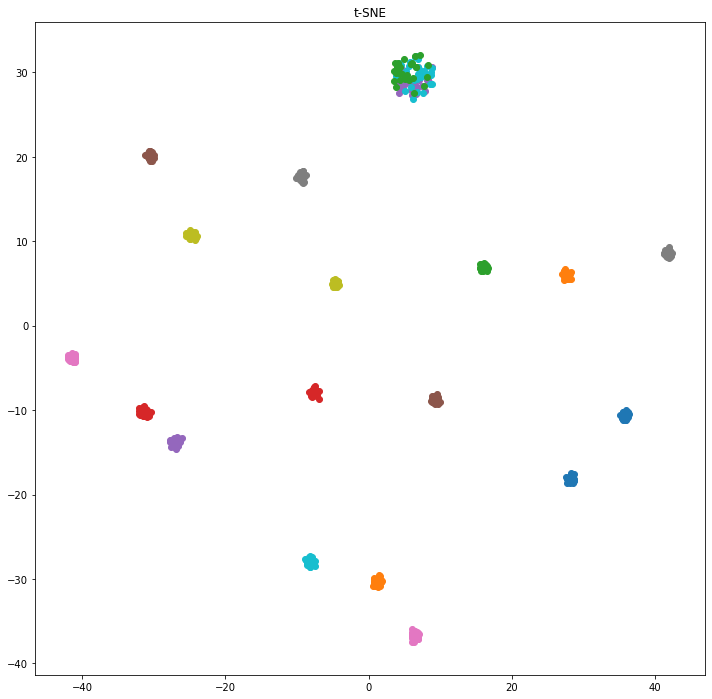

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


data = c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12').to(device)
encoded_data = []
n_sequences = 5
n_variants = 30
for i in range(n_variants):
    encoded_data.append(vae_model.reparameterize(vae_model.encoder(data.x_test[0:n_sequences])).detach().cpu().numpy())
for i in range(n_variants):
    encoded_data.append(vae_model(data.x_test[0:n_sequences])[0].detach().cpu().numpy())
encoded_data = np.array(encoded_data).transpose(1, 0, 2).reshape(-1, 8)


# Then, apply t-SNE
tsne = TSNE(n_components=2, perplexity=60.0, n_iter=1000)
tsne_result = tsne.fit_transform(encoded_data).reshape(n_sequences, n_variants*2, 2)


# Now, let's plot the reductions. You can plot these in two separate scatter plots for comparison.
plt.figure(figsize=(12, 12))
for x in tsne_result:
    plt.scatter(x[:, 0], x[:, 1])
plt.title('t-SNE')

plt.show()


In [ ]:
for i in tsne_result:
    print(i.shape)
    break

(30, 2)





 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 200, 'mid_dim': 256, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 2, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2114.1849, 	 loss test=2097.6251, 	 accuracy test=0.2548, 		 time left = 0h 0m 0s, 		                                     
Epoch 2/3, 	 loss=2092.1355, 	 loss test=2091.8514, 	 accuracy test=0.2625, 		 time left = 0h 0m 0s, 		                                     
Epoch 3/3, 	 loss=2078.1159, 	 loss test=2073.3549, 	 accuracy test=0.2862, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 200, 'mid_dim': 256, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2121.5068, 	 loss test=2099.9467, 	 accuracy test=0.2494, 		 time left = 0h 0m 0s, 		                                     
Epoch 2/3, 	 loss=2092.3433, 	 loss test=2081.4581, 	 accuracy test=0.2738, 		 time left = 0h 0m 0s, 		                                     
Epoch 3/3, 	 loss=2067.0706, 	 loss test=2061.3669, 	 accuracy test=0.3038, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 200, 'mid_dim': 256, 'encoder_type': 'RNN', 'RNN_type': 'LSTM', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 2, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2117.9679, 	 loss test=2101.2885, 	 accuracy test=0.2492, 		 time left = 0h 0m 0s, 		                                     
Epoch 2/3, 	 loss=2097.7862, 	 loss test=2091.7420, 	 accuracy test=0.2613, 		 time left = 0h 0m 0s, 		                                     
Epoch 3/3, 	 loss=2090.1008, 	 loss test=2084.7992, 	 accuracy test=0.2706, 		 time left = 0h 0m 0s, 		             


 ### ----- NEW SWEEP POINT ----- ###

{'emb_dim': 512, 'latent_dim': 16, 'mid_dim': 256, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2121.5381, 	 loss test=2105.5993, 	 accuracy test=0.2385, 		 time left = 0h 4m 13s, 		                                     
Epoch 2/3, 	 loss=2110.0199, 	 loss test=2110.4054, 	 accuracy test=0.2343, 		 time left = 0h 2m 5s, 		                                     
Epoch 3/3, 	 loss=2106.7526, 	 loss test=2102.5331, 	 accuracy test=0.2432, 		 time left = 0h 0m 0s, 	

 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 16, 'mid_dim': 256, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 4, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2139.1348, 	 loss test=2136.1925, 	 accuracy test=0.2000, 		 time left = 0h 4m 59s, 		                                     
Epoch 2/3, 	 loss=2140.2602, 	 loss test=2132.6512, 	 accuracy test=0.2051, 		 time left = 0h 2m 29s, 		                                     
Epoch 3/3, 	 loss=2136.3582, 	 loss test=2139.6701, 	 accuracy test=0.1964, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 16, 'mid_dim': 256, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': False, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2167.8196, 	 loss test=2140.0934, 	 accuracy test=0.1936, 		 time left = 0h 2m 49s, 		                                     
Epoch 2/3, 	 loss=2123.9155, 	 loss test=2117.4370, 	 accuracy test=0.2249, 		 time left = 0h 1m 24s, 		                                     
Epoch 3/3, 	 loss=2117.2727, 	 loss test=2116.0331, 	 accuracy test=0.2273, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 16, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2136.8847, 	 loss test=2132.8969, 	 accuracy test=0.2040, 		 time left = 0h 4m 14s, 		                                     
Epoch 2/3, 	 loss=2128.5431, 	 loss test=2127.8018, 	 accuracy test=0.2107, 		 time left = 0h 2m 7s, 		                                     
Epoch 3/3, 	 loss=2125.0165, 	 loss test=2123.5332, 	 accuracy test=0.2194, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2123.7817, 	 loss test=2114.1331, 	 accuracy test=0.2297, 		 time left = 0h 4m 14s, 		                                     
Epoch 2/3, 	 loss=2096.5591, 	 loss test=2086.0131, 	 accuracy test=0.2694, 		 time left = 0h 2m 6s, 		                                     
Epoch 3/3, 	 loss=2078.8981, 	 loss test=2074.1054, 	 accuracy test=0.2857, 		 time left = 0h 0m 0s, 	                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 16, 'mid_dim': 256, 'encoder_type': 'RNN', 'RNN_type': 'LSTM', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2131.9072, 	 loss test=2118.2118, 	 accuracy test=0.2253, 		 time left = 0h 4m 16s, 		                                     
Epoch 2/3, 	 loss=2114.9468, 	 loss test=2111.2445, 	 accuracy test=0.2345, 		 time left = 0h 2m 8s, 		                                     
Epoch 3/3, 	 loss=2111.7540, 	 loss test=2105.4752, 	 accuracy test=0.2427, 		 time left = 0h 0m 0s, 

 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 4, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2167.7827, 	 loss test=2166.0281, 	 accuracy test=0.1534, 		 time left = 0h 5m 1s, 		                                     
Epoch 2/3, 	 loss=2166.9760, 	 loss test=2166.0236, 	 accuracy test=0.1540, 		 time left = 0h 2m 30s, 		                                     
Epoch 3/3, 	 loss=2166.8611, 	 loss test=2166.4575, 	 accuracy test=0.1540, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 5, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2167.8513, 	 loss test=2165.8446, 	 accuracy test=0.1540, 		 time left = 0h 5m 30s, 		                                     
Epoch 2/3, 	 loss=2166.6663, 	 loss test=2166.0920, 	 accuracy test=0.1540, 		 time left = 0h 2m 45s, 		                                     
Epoch 3/3, 	 loss=2166.5507, 	 loss test=2166.1373, 	 accuracy test=0.1540, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 6, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 4, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2141.2772, 	 loss test=2134.8425, 	 accuracy test=0.2009, 		 time left = 0h 4m 59s, 		                                     
Epoch 2/3, 	 loss=2137.1949, 	 loss test=2131.8297, 	 accuracy test=0.2057, 		 time left = 0h 2m 30s, 		                                     
Epoch 3/3, 	 loss=2133.9491, 	 loss test=2131.7304, 	 accuracy test=0.2056, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 1024, 'latent_dim': 8, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 1024, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2179.7397, 	 loss test=2180.2231, 	 accuracy test=0.1427, 		 time left = 0h 7m 35s, 		                                     
Epoch 2/3, 	 loss=2180.5603, 	 loss test=2180.2224, 	 accuracy test=0.1427, 		 time left = 0h 3m 47s, 		                                     
Epoch 3/3, 	 loss=2180.5591, 	 loss test=2180.2224, 	 accuracy test=0.1427, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 1024, 'latent_dim': 8, 'mid_dim': 1024, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 1024, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2141.6682, 	 loss test=2140.5706, 	 accuracy test=0.1984, 		 time left = 0h 7m 39s, 		                                     
Epoch 2/3, 	 loss=2140.1059, 	 loss test=2133.2287, 	 accuracy test=0.2077, 		 time left = 0h 3m 49s, 		                                     
Epoch 3/3, 	 loss=2129.4567, 	 loss test=2127.2811, 	 accuracy test=0.2145, 		 time left = 0h 0m 0s, 	



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'LSTM', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2120.2024, 	 loss test=2108.5664, 	 accuracy test=0.2366, 		 time left = 0h 4m 15s, 		                                     
Epoch 2/3, 	 loss=2106.5852, 	 loss test=2104.0514, 	 accuracy test=0.2426, 		 time left = 0h 2m 7s, 		                                     
Epoch 3/3, 	 loss=2103.8030, 	 loss test=2103.1045, 	 accuracy test=0.2444, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'LSTM', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 2, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2126.7350, 	 loss test=2116.2579, 	 accuracy test=0.2258, 		 time left = 0h 3m 21s, 		                                     
Epoch 2/3, 	 loss=2107.5284, 	 loss test=2104.0445, 	 accuracy test=0.2438, 		 time left = 0h 1m 33s, 		                                     
Epoch 3/3, 	 loss=2102.5761, 	 loss test=2102.8087, 	 accuracy test=0.2451, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 6, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2126.0559, 	 loss test=2117.6073, 	 accuracy test=0.2273, 		 time left = 0h 3m 53s, 		                                     
Epoch 2/3, 	 loss=2113.8895, 	 loss test=2111.1841, 	 accuracy test=0.2340, 		 time left = 0h 2m 1s, 		                                     
Epoch 3/3, 	 loss=2110.7411, 	 loss test=2109.4323, 	 accuracy test=0.2370, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 512, 'encoder_type': 'RNN', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 1024, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2128.4925, 	 loss test=2115.1247, 	 accuracy test=0.2287, 		 time left = 0h 7m 31s, 		                                     
Epoch 2/3, 	 loss=2114.0968, 	 loss test=2108.3335, 	 accuracy test=0.2388, 		 time left = 0h 3m 45s, 		                                     
Epoch 3/3, 	 loss=2109.6004, 	 loss test=2105.4217, 	 accuracy test=0.2413, 		 time left = 0h 0m 0s, 		



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 100, 'encoder_type': 'conv', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'convs_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)], 'convs_T_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)], 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2108.4102, 	 loss test=2073.1194, 	 accuracy test=0.2844, 		 time left = 0h 3m 40s, 		                                     
Epoch 2/3, 	 loss=2057.2693, 	 loss test=2043.0639, 	 accuracy test=0.3280, 		 time left = 0h 1m 49s, 		                                     
Epoch 3/3, 	 loss=2032.3095, 	 loss test=2023.4990, 	 accuracy test=0.3549, 		 time left = 0h 0m 0s, 	



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 100, 'encoder_type': 'conv', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'convs_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)], 'convs_T_dims': [], 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2167.8927, 	 loss test=2165.9732, 	 accuracy test=0.1540, 		 time left = 0h 3m 12s, 		                                     
Epoch 2/3, 	 loss=2136.9973, 	 loss test=2127.2059, 	 accuracy test=0.2103, 		 time left = 0h 1m 35s, 		                                     
Epoch 3/3, 	 loss=2113.4779, 	 loss test=2097.6955, 	 accuracy test=0.2506, 		 time left = 0h 0m 0s, 		                                     



 ### ----- NEW SWEEP POINT ----- ### 

{'emb_dim': 512, 'latent_dim': 8, 'mid_dim': 100, 'encoder_type': 'conv', 'RNN_type': 'GRU', 'RNN_options': {'hidden_size': 512, 'bidirectional': True, 'num_layers': 3, 'dropout': 0}, 'convs_dims': [], 'convs_T_dims': [('in', 50, 3), (50, 25, 3), (25, 10, 3)], 'n_epochs': 3, 'lr': 0.0003, 'save_name': 'vae_TEST.pickle'} 

Epoch 1/3, 	 loss=2165.2734, 	 loss test=2134.8614, 	 accuracy test=0.1991, 		 time left = 0h 3m 9s, 		                                     
Epoch 2/3, 	 loss=2117.5945, 	 loss test=2092.1470, 	 accuracy test=0.2569, 		 time left = 0h 1m 35s, 		                                     
Epoch 3/3, 	 loss=2080.6995, 	 loss test=2073.1018, 	 accuracy test=0.2856, 		 time left = 0h 0m 0s, 	

In [ ]:
vae_model.encoder(data.x_train[0:10])[0].shape

torch.Size([10, 8])

In [ ]:
data.x_test[0:10].shape

torch.Size([10, 12])

In [ ]:
vae_model(data.x_test[0:10])[0].shape

torch.Size([10, 12, 18])